# Trapped Ion Calculator (TrICal)


This is a package for simulating a chain of trapped ions. The aim of this package is to remove the need for rewriting the same code to calculate equilibrium spacing, normal modes, and $J_{ij}$ every time a trap is being designed.

## Class Structure
![class structure](class_structure.png)

The basic form of the class structure is shown in the diagram. Typically in an ion trap there are three major terms in the potential; the DC part, the RF part and the coulomb part. In this code the user will input the DC and RF parts into the potential class. For the RF potential the pondermotive approximation will have to be taken before inputing the potential into the code. 

## Usage

The typical usage for this code will be to find the normal modes and frequencies for a given trap and for a given set of voltage applied to the trap electrodes. The potential around the centre of the trap is should be calculated via an appropriate method. The results of that calculation can then be input into the Potential class via three methods. The potential class is then used to calculate equilibrium spacing and normal modes. These are in turn fed into the SimulatedSpinLattice class to get out $J_{ij}$ coefficients.

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import matplotlib
from matplotlib import cm
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import trical
import trical.misc.constants as cst
from trical.misc.polynomial import multivariate_polyfit

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True

sym.init_printing()

# TrICal Classes

## Potential Class
The potential class represents a potential applied to the trapped ion system. <br />
Requirements of the potential class are functions corresponding to:
$$
U,\frac{\partial U}{\partial a_i},\frac{\partial^2 U}{\partial a_i \partial b_j}  
$$
where $a,b \in [x,y,z]$ and $1 \leq i,j \leq N$ 

In [3]:
N = 3
dim = 3
mass = cst.convert_m_a(171)


def phi(x):
    x = np.array(x)
    return


def dphi(var):
    a = {"x": 0, "y": 1, "z": 2}[var[0]]
    i = int(var[1:] if type(var) == str else var[1:][0]) - 1

    def dphi_dai(x):
        return 2 * x[i, a]

    return dphi_dai


def d2phi(var1, var2):
    a = {"x": 0, "y": 1, "z": 2}[var1[0]]
    b = {"x": 0, "y": 1, "z": 2}[var2[0]]
    i = int(var1[1:] if type(var1) == str else var1[1:][0]) - 1
    j = int(var2[1:] if type(var2) == str else var2[1:][0]) - 1

    def d2phi_daidbj(x):
        if a == b and i == j:
            return 2
        else:
            return 0

    return d2phi_daidbj


p = trical.classes.Potential(phi, dphi, d2phi, N=N, dim=dim)

p_grad = p.gradient()
p_hess = p.hessian()

x = np.arange(N * dim).reshape(N, dim)

print("Gradient of the potential:")
print(p_grad(x))
print("Hessian of the potential:")
print(p_hess(x))

Gradient of the potential:
[ 0.  6. 12.  2.  8. 14.  4. 10. 16.]
Hessian of the potential:
[[2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2.]]



### CoulombPotential Subclass

The CoulombPotential subclass of Potential represents the coulomb interaction between the ions in the trapped ion system.
$$
U(\{\vec{x}_i\}) = \sum_{i \neq j} \frac{q^2}{4 \pi \epsilon_0} \frac{1}{||\vec{x}_i - \vec{x}_j||_2}
$$

In [4]:
cp = trical.classes.CoulombPotential(N, dim=dim)

### GaussianOpticalPotential Subclass
The GaussianOpticalPotential subclass of Potential represents the potential caused by stark shift from a gaussian beam.
$$
U(\{\vec{x}_i\}) = \frac{\hbar \Omega^2(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2 I(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2}{4 \Delta} \sum_{i} \tilde{I}(\vec{x}_i) \\
\tilde{I}(x,y,z) = I_0 \left(\frac{w_0}{w(x-x^*)}\right)^2 \mathrm{exp} \left({\frac{-2[(y-y^*)^2+(z-z^*)^2]}{w^2(x-x^*)}}\right) \\
w(x) = w_0 \sqrt{1+\left(\frac{x}{x_R}\right)^2}, \quad x_R = \frac{\pi w_0^2 n}{\lambda}, \quad I_0 = \frac{2P}{\pi w_0^2}\\
$$
Where $\vec{x}^*$ is the focal point, $w_0$ is the beam waist, $n$ is the refractive index, $\lambda$ is the wavelength of laser, $P$ is the laser power, $\Delta$ is the detuning from transition, and $\bar{\Omega}$ is the Rabi frequency per root intensity.

In [5]:
focal_point = np.zeros(3)
beam_waist = 1e-6
refractive_index = 1.0
wavelength = 375e-9
power = 1e0
Omega_bar = 3.86e6
transition_wavelength = 369.52e-9

gop = trical.classes.GaussianOpticalPotential(
    focal_point,
    power,
    wavelength,
    beam_waist,
    mass=mass,
    Omega_bar=Omega_bar,
    transition_wavelength=transition_wavelength,
    refractive_index=refractive_index,
)

### PolynomialPotential Subclass

The PolynomialPotential approximates your trapping potential in the region around the ion chain with the following multivariate polynomial:
$$
U(\{\vec{x}_i\}) = \sum_{i} \tilde{U}(\vec{x}_i) \\
\tilde{U}(x,y,z) = \sum_{ijk} \alpha_{ijk}  x^iy^jz^k
$$

In [6]:
mass = cst.convert_m_a(171)
omega_x = 2 * np.pi * 0.4e6  # Hz
omega_y = 2 * np.pi * 0.36e6  # Hz
omega_z = 2 * np.pi * 0.08e6  # Hz

# Potential in Joules
alpha = np.zeros((3, 3, 3))
alpha[2, 0, 0] = mass * (omega_x) ** 2 / 2  # alpha_2,0,0
alpha[0, 2, 0] = mass * (omega_y) ** 2 / 2  # alpha_0,2,0
alpha[0, 0, 2] = mass * (omega_z) ** 2 / 2  # alpha_0,0,2

pp = trical.classes.PolynomialPotential(alpha)
print(alpha)

[[[0.00000000e+00 0.00000000e+00 3.58719448e-14]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [7.26406883e-13 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[8.96798621e-13 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


#### Fitting to a PolynomialPotential
The second method of defining a potential is to give a grid of points with the potential at each point. This grid will then be fit with polynomial and the coefficients of the polynomial will be returned in a format that can be submitted to the PolynomialPotential class via the first example method.

The format for submitting the grid to the fitting function is in two arrays. The first is a list of \[x,y,z\] positions, and the second is a list of the value of the potential at each point.

In [7]:
I_x = np.linspace(-2e-4, 2e-4, 81)
I_y = np.linspace(-2e-4, 2e-4, 81)
I_z = np.linspace(-5e-4, 5e-4, 201)

r = np.array(np.meshgrid(I_x, I_y, I_z))
r = r.reshape(3, -1).transpose()

f = lambda x, y, z: np.polynomial.polynomial.polyval3d(x, y, z, alpha)

U_r = f(*r.transpose())

l = 1e-6
deg = (2, 2, 2)
alpha_fit = multivariate_polyfit(r, U_r, deg)
print(alpha_fit)

pfp = trical.classes.PolynomialPotential(alpha_fit)

[[[-8.23788635e-33  5.04870979e-29  3.58719448e-14]
  [-2.27550602e-29 -4.96024545e-28 -1.02965008e-23]
  [ 7.26406883e-13 -4.38522899e-24  1.41488681e-20]]

 [[-2.34269114e-29 -1.96064576e-28 -1.12896031e-24]
  [-8.13820454e-28 -3.56444845e-24  1.84971276e-20]
  [-7.46849531e-24  3.19369691e-20 -3.75426743e-21]]

 [[ 8.96798621e-13 -2.91128112e-24  1.36703483e-20]
  [ 1.77718025e-23  4.78681837e-20 -7.03006607e-21]
  [ 8.51172350e-20 -4.32216971e-22 -7.82573409e-22]]]


### SymbolicPotential Subclass
The third method is to insert a symbolic expression using sympy for the potential. This is intended to be useful when you have an analytical expression for your trapping potential. All ions must have the same potential, i.e.
$$
U(\{\vec{x}_i\}) = \sum_{i} \tilde{U}(\vec{x}_i)
$$

In [8]:
x, y, z = sym.symbols("x, y ,z")
expr = (
    mass * (omega_x) ** 2 / 2 * x ** 2
    + mass * (omega_y) ** 2 / 2 * y ** 2
    + mass * (omega_z) ** 2 / 2 * z ** 2
)
print(expr)

sp = trical.classes.SymbolicPotential(expr)

8.96798620563919e-13*x**2 + 7.26406882656774e-13*y**2 + 3.58719448225568e-14*z**2


#### SymbolicOpticalPotential
$$
U(\{\vec{x}_i\}) = \frac{\hbar \Omega^2(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2 I(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2}{4 \Delta} \sum_{i} \tilde{I}(\vec{x}_i)
$$

In [9]:
focal_point = np.zeros(3)
beam_waist = 1e-6
refractive_index = 1.0
wavelength = 375e-9
power = 1e0
Omega_bar = 3.86e6
transition_wavelength = 369.52e-9

x, y, z = sym.symbols("x, y ,z")
delta_x, delta_y, delta_z = np.array([x, y, z]) - focal_point

x_R = np.pi * beam_waist ** 2 * refractive_index / wavelength
w = beam_waist * sym.sqrt(1 + (delta_x / x_R) ** 2)
intensity_expr = (
    2
    * power
    / (np.pi * beam_waist ** 2)
    * (beam_waist / w) ** 2
    * sym.exp(-2 * (delta_y ** 2 + delta_z ** 2) / w ** 2)
)

sop = trical.classes.SymbolicOpticalPotential(
    intensity_expr,
    wavelength,
    Omega_bar=Omega_bar,
    transition_wavelength=transition_wavelength,
)

### AdvancedSymbolicPotential Subclass
This subclass of Potential represents a potential that can be ion dependent symbolically, i.e.
$$
U(\{\vec{x}_i\}) = \sum_{i} \tilde{U}_i(\vec{x}_i)
$$
This means this class works for an arbitrary potential.

In [10]:
x = np.array(sym.symbols(" ".join(["x{}".format(i) for i in range(N)])))
y = np.array(sym.symbols(" ".join(["y{}".format(i) for i in range(N)])))
z = np.array(sym.symbols(" ".join(["z{}".format(i) for i in range(N)])))

expr = (
    (mass * omega_x ** 2 * x ** 2 / 2).sum()
    + (mass * omega_y ** 2 * y ** 2 / 2).sum()
    + (mass * omega_z ** 2 * z ** 2 / 2).sum()
)

asp = trical.classes.AdvancedSymbolicPotential(N, expr)

### AutoDiffPotential Subclass
The fourth method is to use a function representing the potential and uses automatic differentiation to take the derivatives. This is intended to be useful when you have an analytical expression for your trapping potential. This class works for an arbitrary potential. Using the same potential as the first example.

In [11]:
import autograd as ag
from autograd import numpy as agnp

expr = lambda x: (
    mass * (omega_x) ** 2 / 2 * x[:, 0] ** 2
    + mass * (omega_y) ** 2 / 2 * x[:, 1] ** 2
    + mass * (omega_z) ** 2 / 2 * x[:, 2] ** 2
).sum()

adp = trical.classes.AutoDiffPotential(expr)

#### OpticalPotential Subclass
$$
U(\{\vec{x}_i\}) = \frac{\hbar \Omega^2(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2 I(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2}{4 \Delta} \sum_{i} \tilde{I}(\vec{x}_i)
$$

In [12]:
focal_point = np.zeros(3)
beam_waist = 1e-6
refractive_index = 1.0
wavelength = 375e-9
power = 1e0
Omega_bar = 3.86e6
transition_wavelength = 369.52e-9


def intensity_expr(x):
    delta_x = x - focal_point
    x_R = np.pi * beam_waist ** 2 * refractive_index / wavelength
    w = beam_waist * agnp.sqrt(1 + (delta_x[:, 0] / x_R) ** 2)
    return (
        2
        * power
        / (np.pi * beam_waist ** 2)
        * (beam_waist / w) ** 2
        * agnp.exp(-2 * (delta_x[:, 1] ** 2 + delta_x[:, 2] ** 2) / w ** 2)
    ).sum()


op = trical.classes.OpticalPotential(
    intensity_expr,
    wavelength,
    Omega_bar=Omega_bar,
    transition_wavelength=transition_wavelength,
)

## TrappedIons Class

This class calculates the equilibrium positions, normal modes, and frequencies of a given number of ions and trapping potential. The method of inputing the potential should not have any bearing on the equilibrum position. Using the equilibrium_position funciton we can see that all three input methods give the same positions in z.

In [13]:
ti_pp = trical.classes.TrappedIons(N, pp, m=mass)
ti_pfp = trical.classes.TrappedIons(N, pfp, m=mass)
ti_sp = trical.classes.TrappedIons(N, sp, m=mass)
ti_asp = trical.classes.TrappedIons(N, asp, m=mass)
ti_adp = trical.classes.TrappedIons(N, adp, m=mass)

print("{:=^100}".format(" PolynomialPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_pp.principle_axis()
print("{}:{}".format("Equilibrium Position (micron)", np.round(ti_pp.x_ep[:, 2] * 1e6, 5)))
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_pp.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_pp.b_pa, 5))

print("{:=^100}".format(" Fitted PolynomialPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_pfp.principle_axis()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_pfp.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_pfp.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_pfp.b_pa, 5))

print("{:=^100}".format(" SymbolicPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_sp.principle_axis()
print("{}:{}".format("Equilibrium Position (micron)", np.round(ti_sp.x_ep[:, 2] * 1e6, 5)))
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_sp.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_sp.b_pa, 5))

print("{:=^100}".format(" AdvancedSymbolicPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_asp.principle_axis()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_asp.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_asp.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_asp.b_pa, 5))

print("{:=^100}".format(" AutoDiffPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_adp.principle_axis()
print("{}:{}".format("Equilibrium Position (micron)", np.round(ti_adp.x_ep[:, 2] * 1e6, 5)))
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_adp.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_adp.b_pa, 5))

======================================= PolynomialPotential ========================================
Execution time for principle axis method:
8.97 ms ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (MHz):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
Eigenvectors:
[[ 0.57735 -0.70711  0.40825 -0.      -0.      -0.       0.       0.
  -0.     ]
 [ 0.57735 -0.      -0.8165   0.       0.       0.       0.       0.
  -0.     ]
 [ 0.57735  0.70711  0.40825 -0.      -0.      -0.      -0.      -0.
  -0.     ]
 [ 0.       0.       0.       0.57735  0.70711  0.40825 -0.       0.
  -0.     ]
 [-0.       0.       0.       0.57735  0.      -0.8165   0.      -0.
  -0.     ]
 [-0.      -0.      -0.       0.57735 -0.70711  0.40825 -0.      -0.
  -0.     ]
 [ 0.      -0.      -0.      -0.       0.       0.       0.40825 -0.70711
   0.57735]
 [ 0.      -0.       0.       0.       0

In [14]:
ti_gop = trical.classes.TrappedIons(N, adp, gop, m=mass)
ti_sop = trical.classes.TrappedIons(N, adp, sop, m=mass)
ti_op = trical.classes.TrappedIons(N, adp, op, m=mass)

print("{:=^100}".format(" GaussianOpticalPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_gop.principle_axis()
print(
    "{}:{}".format("Equilibrium Position (micron)", np.round(ti_gop.x_ep[:, 2] * 1e6, 5))
)
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_gop.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_gop.b_pa, 5))

print("{:=^100}".format(" SymbolicOpticalPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_sop.principle_axis()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_sop.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_sop.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_sop.b_pa, 5))

print("{:=^100}".format(" OpticalPotential "))
print("{}:".format("Execution time for principle axis method"))
%timeit ti_op.principle_axis()
print(
    "{}:{}".format("Equilibrium Position (micron)", np.round(ti_op.x_ep[:, 2] * 1e6, 5))
)
print("{}:{}".format("Eigenfrequencies (MHz)", np.round(ti_op.w_pa / 1e6, 5)))
print("{}:".format("Eigenvectors"))
print(np.round(ti_op.b_pa, 5))

===================================== GaussianOpticalPotential =====================================
Execution time for principle axis method:
7.41 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (MHz):[2.5447  2.4625  2.42654 7.21141 2.21642 2.20539 6.95403 0.87062 0.80627]
Eigenvectors:
[[ 0.4389  -0.70711  0.5544  -0.      -0.      -0.      -0.       0.
   0.     ]
 [ 0.78404 -0.      -0.6207   0.       0.       0.       0.      -0.
  -0.     ]
 [ 0.4389   0.70711  0.5544  -0.      -0.      -0.       0.      -0.
   0.     ]
 [-0.      -0.       0.       0.00429  0.70709  0.70711 -0.       0.
   0.     ]
 [ 0.      -0.       0.       0.99998 -0.00607 -0.       0.      -0.
   0.     ]
 [ 0.      -0.       0.       0.00429  0.70709 -0.70711  0.       0.
  -0.     ]
 [ 0.       0.      -0.       0.      -0.      -0.       0.00847  0.70711
   0.70706]
 [-0.       0.      -0.      -0.       0.

## SimulatedSpinLattice Class

This class takes in a TrappedIons class and using the eigenmodes produces a Jij coupling matrix along some axis with the axis, wavelength, detuning and adressing being input parameters.


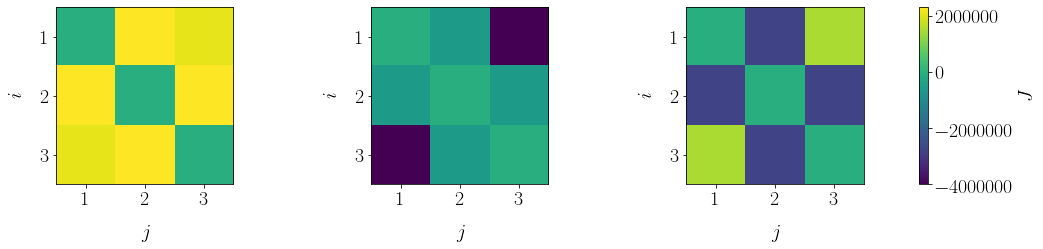

In [16]:
wavelength = 355e-9

detuning = 2 * np.pi * 1e3
mu = np.array([np.array([ti_adp.w_pa[:N][i] + detuning]) for i in range(N)])
omega = np.full((N, 1), 1e6)

ssl = [
    trical.classes.SimulatedSpinLattice(ti_adp, mu[i], omega, k=2 * np.pi / wavelength)
    for i in range(N)
]

J = np.array([ssl[i].J for i in range(N)])

norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(4, 3, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
    ax[i].set_xlabel(r"$j$", labelpad=15)
    ax[i].set_ylabel(r"$i$", labelpad=15)
fig.colorbar(sm, ax=ax, label=r"$J$")

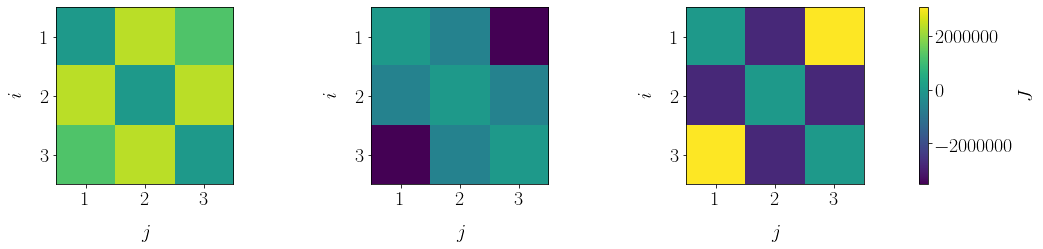

In [17]:
wavelength = 355e-9

detuning = 2 * np.pi * 1e3
mu = np.array([np.array([ti_gop.w_pa[:N][i] + detuning]) for i in range(N)])
omega = np.full((N, 1), 1e6)

ssl = [
    trical.classes.SimulatedSpinLattice(ti_gop, mu[i], omega, k=2 * np.pi / wavelength)
    for i in range(N)
]

J = np.array([ssl[i].J for i in range(N)])

norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(4, 3, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
    ax[i].set_xlabel(r"$j$", labelpad=15)
    ax[i].set_ylabel(r"$i$", labelpad=15)
fig.colorbar(sm, ax=ax, label=r"$J$")